# SAC

For ReLAx & Mujoco installation see:
https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding SAC:
- SAC paper: https://arxiv.org/abs/1801.01290
- SAC description: https://spinningup.openai.com/en/latest/algorithms/sac.html

!Note: For examining trained actor you may just load trained policies from \trained_models directory.
To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_sac_example

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import SAC
from relax.rl.critics import CDQN

from relax.zoo.policies import TanhNormalMLP
from relax.zoo.critics import ContQMLP

from relax.schedules import PiecewiseSchedule

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

from relax.gym.utils import visualize_actor

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constructing Actor's stochastic policy

SAC is a continuous control algorithm with a stochastic policy. The key idea of SAC is to maximize policy's entropy along with RL objective to ensure maximum exploration over the entire course of training. SAC policy is a network that takes a batch of observations with a shape (BATCH_SIZE, \*obs.shape) and produces 2 output streams: 1) actions means stream with output shape (BATCH_SIZE, ACS_DIM), 2) actions log(std) stream with output shape (BATCH_SIZE, ACS_DIM). These two streams should parameterize Tanh squashed multivariate normal distribution (implementation that should be used is provided: relax.zoo.distributions.TanhNormal). So, to sum up, overall policy takes as an input a batch of observations with a shape (BATCH_SIZE, \*obs.shape) and outputs relax.zoo.distributions.TanhNormal distribution (which is a subclass of torch distribution). 

Therefore any custom user defined networks meeting this requirements should work well 
with SAC actor

So let's examine the default implementation of TanhNormal policy offered by ReLAx:

In [2]:
print(getsource(TanhNormalMLP))

class TanhNormalMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 acs_scale=1, acs_bias=0,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 init_w=3e-3, 
                 min_log_std=-20, 
                 max_log_std=2):
        
        super(TanhNormalMLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(obs_dim, hidden1))
        layers.append(activation)
        layers.append(nn.Linear(hidden1, hidden2))
        layers.append(activation)
        self.hidden_layers = nn.Sequential(*layers)
        
        self.mean_layer_linear = nn.Linear(hidden2, acs_dim)
        self.mean_layer_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_layer_linear.bias.data.uniform_(-init_w, init_w)
        self.mean_layer = nn.Sequential(
            self.mean_layer_linear,
            out_activation
        )
        
        self.log

# Constructing Continuous Deep Q-Network Critic

Actor's stochastic policy is trained in pair with  2 critic networks which approximate Q-Function for a given observation-action pair. That means that critic net is taking as an input an observations batch with a shape of (BATCH_SIZE, \*obs.shape) and a batch of corresponding actions with a shape (BATCH_SIZE, ACS_DIM) and outputting Q-Values batch with a shape (BATCH_SIZE, 1).

Therefore any custom user defined networks meeting this requirements should work well with CDQN critic

So let's examine the default implementation of Continuous Deep Q-Network Critic offered by ReLAx:

In [3]:
print(getsource(ContQMLP))

class ContQMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 init_w=3e-3):
        
        super(ContQMLP, self).__init__()
        
        self.fc1 = nn.Linear(obs_dim+acs_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.activation = activation
        self.out_activation = out_activation
        self.acs_dim = acs_dim
        
    def forward(self, obs, acs):
        
        out = self.fc1(
            torch.cat(
                [torch.flatten(obs, start_dim=1), acs], 
                dim=-1
            )
        )
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.out_activation(out)
        
        return out



# Define Schedules for Training:

Our SAC actor will not learn for the first 10k iterations. (Told to actor by passing 0 learning rate for the first 10k iterations)

And it will also conduct maximum exploration during that phase to collect initial random training data. 

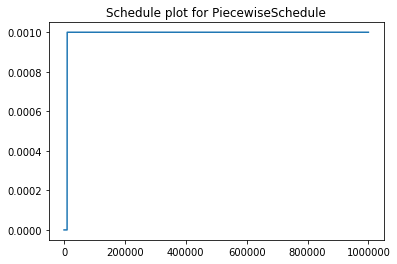

In [4]:
# Creating schedules:
# first 10000 iterations no learning - just data collection
policy_lr = PiecewiseSchedule({0: 10000}, 1e-3)
critic_lr = PiecewiseSchedule({0: 10000}, 1e-3)
policy_lr.plot(int(1e6))

# Create training and eval environments

In [5]:
env_name = 'Hopper-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[15]

In [6]:
env.action_space, env.action_space.high, env.action_space.low

(Box(3,),
 array([1., 1., 1.], dtype=float32),
 array([-1., -1., -1.], dtype=float32))

In [7]:
env.observation_space

Box(11,)

In [8]:
acs_dim = 3
obs_dim = 11

# Set Up Exploration

As SAC maximizes policy's entropy there is no need for any additional exploration that alters policy's actions. Furthermore, SAC is able to learn complex observation-dependent exploration strategies over the course of training. This is achieved by the fact that log(std)'s that parameterize TanhNormal distribution are themselves parameterized by state-dependent neural network.

# Define SAC actor:

In [9]:
actor = SAC(
    device=torch.device('cuda'),
    policy_net=TanhNormalMLP(obs_dim, acs_dim),
    auto_tune_alpha=True,
    target_entropy=-acs_dim,
    learning_rate=policy_lr,
    batch_size=100,
    n_random_steps=10000,
    min_acs=-1,
    max_acs=1
)

# Define CDQN critic:

!Note: SAC is using 2 critic networks instead of 1 just like TD3. That means that CDQN initialization is the same like TD3!

In [10]:
critic = CDQN(
    critic_net=ContQMLP(obs_dim, acs_dim),
    critic_net2=ContQMLP(obs_dim, acs_dim),
    device=torch.device('cuda'),
    learning_rate=critic_lr,
    weight_decay=0.0
)

# Provide actor with critic:

!Note: Unlike A2C or PPO/TRPO + GAE architectures SAC updates actor and critic on the same batch of data, so critic is updated implicitly inside actor's update() method. Still, CDQN critic has its own update() method which is created to step schedules and follow the general API

In [11]:
actor.set_critic(critic)

# Create replay buffer and wrap envs into Sampler:

In [12]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)


replay_buffer = ReplayBuffer(int(1e+6))

# Visualize untrained actor

In [13]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 184.14505530751399
Loading video...


# Run Training and Validation loop:

In [15]:
log_every = 10000
n_steps = 1000000
logdir = '/home/nikita/Desktop/RelaxExamples/SAC/tensorboard_logs'
run_name = 'sac_hopper'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    unit_pathlist = sampler.sample(actor=actor,
                                   n_transitions=1,
                                   max_path_length=None, 
                                   reset_when_not_done=False,
                                   train_sampling=True)
    
    # add transitions to replay buffer
    replay_buffer.add_paths(unit_pathlist)
    
    # update critic
    critic_logs = critic.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0 and step > 0:
        
        # create logs of buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')
        
        # evaluating the policy
        eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                    n_episodes=5,
                                                    max_path_length=None, 
                                                    train_sampling=False)
        eval_logs = eval_batch.create_logs(prefix='eval')
        logs = {**critic_logs,
                **actor_logs,
                **buffer_logs,
                **eval_logs}
        all_logs.append(logs)
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 1000000/1000000 [5:57:41<00:00, 46.60it/s]  


In [14]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/SAC/tensorboard_logs

# Plot learning curve

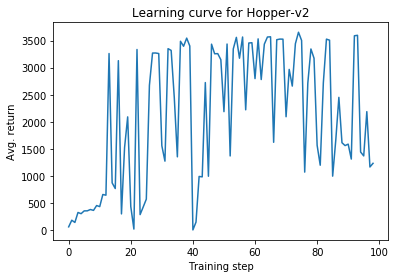

In [20]:
eval_score = [l['avg_return/eval'] for l in all_logs]
plt.plot(eval_score)
plt.title(f'Learning curve for {env_name}')
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Plot estimated vs actual Q-values

('avg_return', 3582.1223257024476)
('std_return', 35.2816257710153)
('max_return', 3638.256482879256)
('min_return', 3527.4813392177184)
('mean_pathlen', 1000.0)
('n_paths', 10)
('n_transitions', 10000)


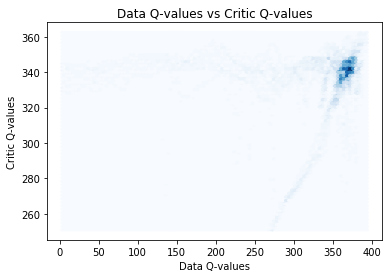

In [35]:
batch = eval_sampler.sample_n_episodes(actor=actor,
                                       n_episodes=10,
                                       max_path_length=None, 
                                       train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

batch.add_disc_cumsum(cumsum_field='q_vals', field='rews', gamma=0.99)
data_q_values = batch.unpack(['q_vals'])

model_q_values = critic.estimate_qvalue(batch)

plt.hexbin(data_q_values, model_q_values, bins=50, cmap=plt.cm.Blues)
plt.title('Data Q-values vs Critic Q-values')
plt.xlabel('Data Q-values')
plt.ylabel('Critic Q-values')
plt.show()

# Visualize trained actor

In [36]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 3608.4217337075474
Loading video...


# Save Models

In [17]:
actor.save_checkpoint('trained_models', 'sac_actor')
critic.save_checkpoint('trained_models', 'sac_critic')

Saved checkpoints for SAC...
models_state_dict global_step local_step n_updates optimizer scheduler alpha_optimizer alpha_scheduler
Saved checkpoints for CDQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler optimizer2 scheduler2


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load Models

In [ ]:
actor.load_checkpoint('trained_models', 'sac_actor')
critic.load_checkpoint('trained_models', 'sac_critic')